In [12]:
%matplotlib inline


# Spectral Unmixing


Suhas Somnath, Rama K. Vasudevan, Stephen Jesse

* Institute for Functional Imaging of Materials
* Center for Nanophase Materials Sciences

Oak Ridge National Laboratory, Oak Ridge TN 37831, USA

In this notebook we load some spectral data, and perform basic data analysis, including:
========================================================================================
* KMeans Clustering
* Non-negative Matrix Factorization
* Singular Value Decomposition


Software Prerequisites:
=======================
* Standard distribution of **Anaconda** (includes numpy, scipy, matplotlib and sci-kit learn)
* **pycroscopy** : Though pycroscopy is mainly used here for plotting purposes only, it's true capabilities
  are realized through the ability to seamlessly perform these analyses on any imaging dataset (regardless
  of origin, size, complexity) and storing the results back into the same dataset among other things




In [13]:
# Import packages

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals

# basic numeric computation:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Plotting and visualization:
import matplotlib.pyplot as plt

import os

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, FastICA
import subprocess
import sys

import pyUSID as usid
import pycroscopy as px
from pycroscopy.viz import cluster_utils

The Data
========

In this example, we will work on a **Band Excitation Piezoresponse Force Microscopy (BE-PFM)** imaging dataset
acquired from advanced atomic force microscopes. In this dataset, a spectra was collected for each position in a two
dimensional grid of spatial locations. Thus, this is a three dimensional dataset that has been flattened to a two
dimensional matrix in accordance with the pycroscopy data format.

Fortunately, all statistical analysis, machine learning, spectral unmixing algorithms, etc. only accept data that is
formatted in the same manner of [position x spectra] in a two dimensional matrix.

We will be using an data file available on our GitHub project page by default. You are encouraged
to download this document as a Jupyter Notebook (button at the bottom of the page) and use your own data instead.
When using your own data, you can skip this cell and provide the path to your data using the variable - data_file_path



In [14]:
data_file_path = r'data/Signal_SI.h5'

h5_file = h5py.File(data_file_path, mode='r+')

print('Contents of data file:')
print('----------------------')
usid.hdf_utils.print_tree(h5_file)
print('----------------------')


Contents of data file:
----------------------
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Image
  ├ Channel_001
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-Cluster_000
      --------------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ Raw_Data-Cluster_001
      --------------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ Raw_Data-Decomposition_000
      --------------------------
      ├ Components
      ├ Position_Indices
      ├ Position_Values
      ├ Projection
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Raw_Data-Decomposition_001
      --------------------------
      ├ Components
      ├ Position_Indices
      ├ Position_Values
      ├ Projection
      ├ Spectroscopic

In [15]:
#Get the image
h5_meas_grp = h5_file['Measurement_000']

h5_image =  h5_meas_grp['Channel_000/Image']

# Getting a reference to the main spectral dataset:
h5_main = usid.USIDataset(h5_meas_grp['Channel_001/Raw_Data'])

# Extracting the X axis - vector of frequencies
h5_spec_vals = usid.hdf_utils.get_auxiliary_datasets(h5_main, 'Spectroscopic_Values')[-1]

print('Data currently of shape:', h5_main.shape)

[num_rows,num_cols] = h5_main.pos_dim_sizes
num_spect = h5_main.spec_dim_sizes[0]


Data currently of shape: (775, 512)


In [16]:
#Get X,Y labels
x_label = h5_main.spec_dim_descriptors[0]
y_label = h5_main.data_descriptor

# Visualize the Data

Some basic code to slice the data and visuzlie it using matplotlib

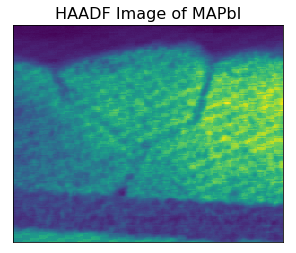

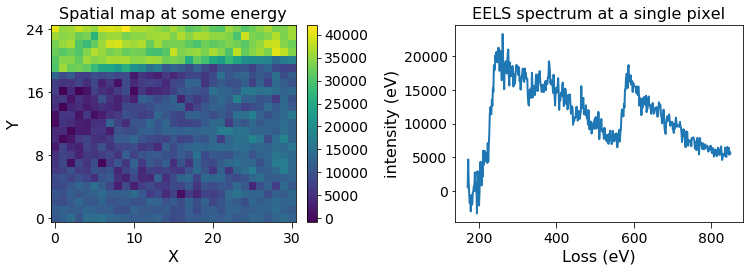

In [17]:
#Plot the image, and some spectra

fig, axes = plt.subplots()
axes.imshow(h5_image)
axes.set_title('HAADF Image of MAPbI')
axes.set_xticks([])
axes.set_yticks([])

#Now plot some slices of the 3D data cube (the EELS spectra)
usid.plot_utils.use_nice_plot_params()

fig2, axes2 = plt.subplots(ncols=2, figsize=(11,4))
spat_map = np.reshape(h5_main[:, num_spect//2], (num_rows, num_cols))

usid.plot_utils.plot_map(axes2[0], spat_map, origin='lower')

axes2[0].set_title('Spatial map at some energy')
axes2[0].set_xlabel('X')
axes2[0].set_ylabel('Y')
axes2[1].plot(h5_spec_vals[:].ravel(),
             h5_main[num_rows*num_cols//3])

axes2[1].set_title('EELS spectrum at a single pixel')
axes2[1].set_xlabel(x_label)
axes2[1].set_ylabel(y_label)

fig2.tight_layout()

# 1. Singular Value Decomposition (SVD)
=====================================

SVD is an eigenvector decomposition that is defined statistically, and therefore typically produces
non-physical eigenvectors. Consequently, the interpretation of eigenvectors and abundance maps from
SVD requires care and caution in interpretation. Nonetheless, it is a good method for quickly
visualizing the major trends in the dataset since the resultant eigenvectors are sorted in descending
order of variance or importance. Furthermore, SVD is also very well suited for data cleaning through
the reconstruction of the dataset using only the first N (most significant) components.

SVD results in three matrices:

* V - Eigenvectors sorted by variance in descending order
* U - corresponding abundance maps
* S - Variance or importance of each of these components

Advantage of pycroscopy:
------------------------
Notice that we are working with a complex valued dataset. Passing the complex values as is to SVD would result in
complex valued eigenvectors / endmembers as well as abundance maps. Complex valued abundance maps are not physical.
Thus, one would need to restructure the data such that it is real-valued only.

One solution is to stack the real value followed by the magnitude of the imaginary component before passing to SVD.
After SVD, the real-valued eigenvectors would need to be treated as the concatenation of the real and imaginary
components. So, the eigenvectors would need to be restructured to get back the complex valued eigenvectors.

**Pycroscopy handles all these data transformations (both for the source dataset and the eigenvectors)
automatically.**  In general, pycroscopy handles compound / complex valued datasets everywhere possible

Furthermore, while it is not discussed in this example, pycroscopy also writes back the results from SVD back to
the same source h5 file including all relevant links to the source dataset and other ancillary datasets



Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: SVD has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_001/Raw_Data-SVD_000" (7 members)>]
Returning previously computed results from: /Measurement_000/Channel_001/Raw_Data-SVD_000
set the "override" flag to True to recompute results


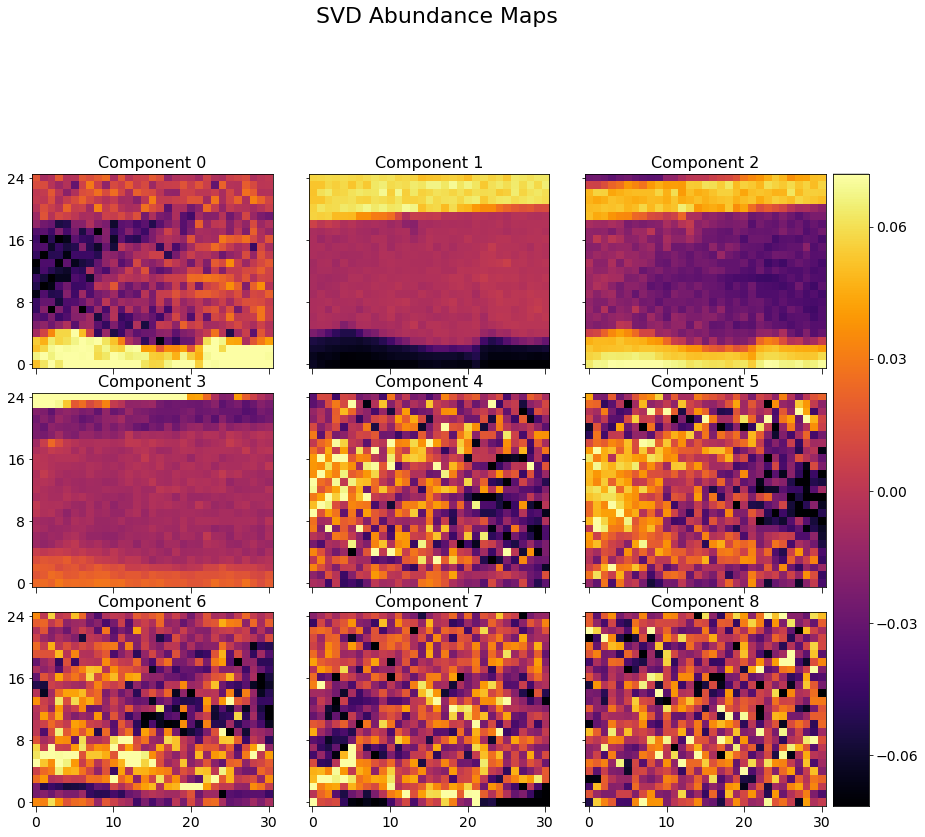

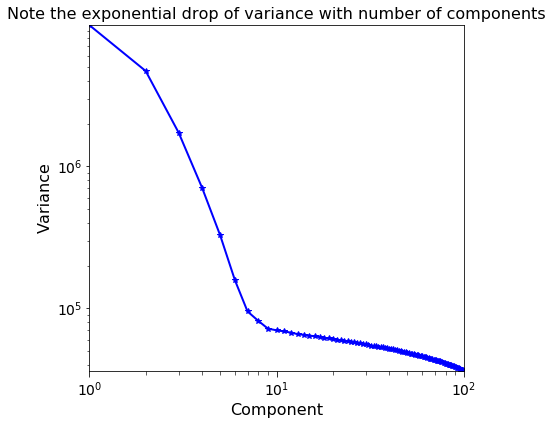

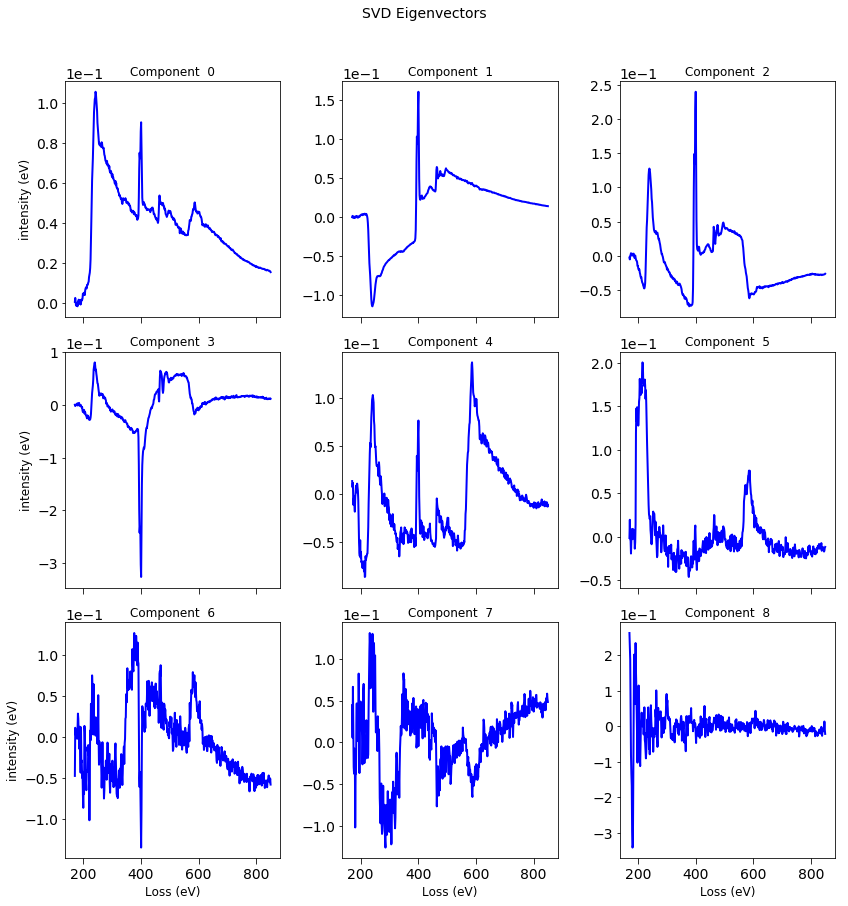

In [18]:
decomposer = px.processing.svd_utils.SVD(h5_main, num_components=100)
h5_svd_group = decomposer.compute()

h5_u = h5_svd_group['U']
h5_v = h5_svd_group['V']
h5_s = h5_svd_group['S']

# Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
abun_maps = np.reshape(h5_u[:, :25], (num_rows, num_cols, -1))

usid.plot_utils.plot_map_stack(abun_maps, num_comps=9, title='SVD Abundance Maps', reverse_dims=True,
                             color_bar_mode='single', cmap='inferno', title_yoffset=0.95)


# Visualize the variance / statistical importance of each component:
usid.plot_utils.plot_scree(h5_s, title='Note the exponential drop of variance with number of components')

# Visualize the eigenvectors:
_ = usid.plot_utils.plot_curves(h5_spec_vals[:].ravel(), h5_v[:9, :], x_label=x_label, y_label=y_label,
                                       title='SVD Eigenvectors', evenly_spaced=False, subtitle_prefix = 'Component ')

# 2. Non-negative Matrix Factorization (NMF)
===========================================

NMF, or non-negative matrix factorization, is a method that is useful towards unmixing of spectral
data. It only works on data with positive real values. It operates by approximate determination of
factors (matrices) W and H, given a matrix V, as shown below

![](https://upload.wikimedia.org/wikipedia/commons/f/f9/NMF.png)


Unlike SVD and k-Means that can be applied to complex-valued datasets, NMF only works on non-negative datasets.
For illustrative purposes, we will only take the amplitude component of the spectral data



Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: Decomposition has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_001/Raw_Data-Decomposition_000" (6 members)>]
Returning previously computed results from: /Measurement_000/Channel_001/Raw_Data-Decomposition_000
set the "override" flag to True to recompute results


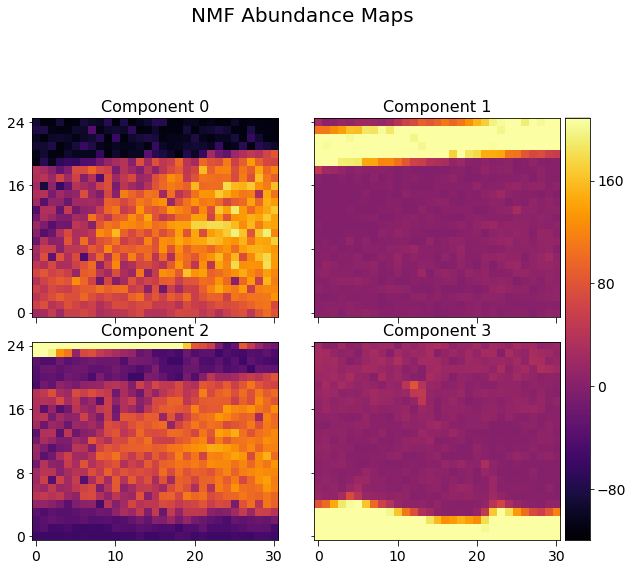

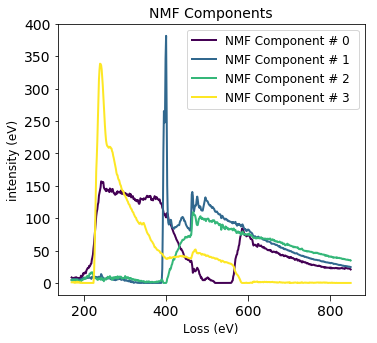

In [19]:
num_comps = 4

#Choose the NMFmodel from sklearn
nmf_model = NMF(n_components=num_comps, init='random', random_state=0)

data_mat = np.abs(h5_main[:]) #get the data, ensuring it is positive only.

#pycroscopy can handle this decomposition given an sklearn estimator object
decomposer = px.processing.decomposition.Decomposition(h5_main, estimator =nmf_model)
h5_nmf_group = decomposer.compute() #compute it. Saves results into the file and returns reference to it.

components = h5_nmf_group['Components'] #Components 
projection  = h5_nmf_group['Projection'] #Coefficients/scores

nmf_coeffs_fig = usid.plot_utils.plot_map_stack(projection[:].reshape(num_rows,num_cols,-1), num_comps=9, title='NMF Abundance Maps', reverse_dims=True,
                             color_bar_mode='single', cmap='inferno', title_yoffset=0.95)

# Visualize the components:
nmf_comp_fig, axis = plt.subplots(figsize=(5.5, 5))
usid.plot_utils.plot_line_family(axis, h5_spec_vals[:].ravel(), components, label_prefix='NMF Component #')
axis.set_xlabel(x_label, fontsize=12)
axis.set_ylabel(y_label, fontsize=12)
axis.set_title('NMF Components', fontsize=14)
axis.legend(bbox_to_anchor=[1.0, 1.0], fontsize=12)


# 3. Independent Component Analysis (ICA)
===========================================

ICA can be a useful tool when the signal arises from multiple independent sources. From a physics perspective if there are multiple mechanisms that produce the measured signal that have limited interaction between each other, then ICA can be a useful tool. Unfortauntely, as with SVD or PCA, the components often end up having unphysical values. Still, it can be insightful (for an instructive example, see Vasudevan et al., Journal of Applied Physics 118, 072003 (2015)).

As with NMF, the user must specify the number of components to use. In practice, one can always start with a high number (e.g., 10) and reduce them until no two components look 'alike'. More rigorous mathematical methods to determine the otpimal number of components are also possible, but are beyond the scope of this workshop. The distinction between NMF and ICA is that ICA allows negativity in the matrices, and the components are chosen such that independence of components(defined in some mathematical way, such as maximally non-Gaussian) is obtained.

The algorithm used is the FastICA algorithm implemented in scikit-learn, which is based on A. Hyvarinen and E. Oja, Independent Component Analysis: Algorithms and Applications, Neural Networks, 13(4-5), 2000, pp. 411-430

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: Decomposition has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_001/Raw_Data-Decomposition_001" (6 members)>]
Returning previously computed results from: /Measurement_000/Channel_001/Raw_Data-Decomposition_001
set the "override" flag to True to recompute results
Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: Decomposition has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_001/Raw_Data-Decomposition_001" (6 members)>]
Returning previously computed results

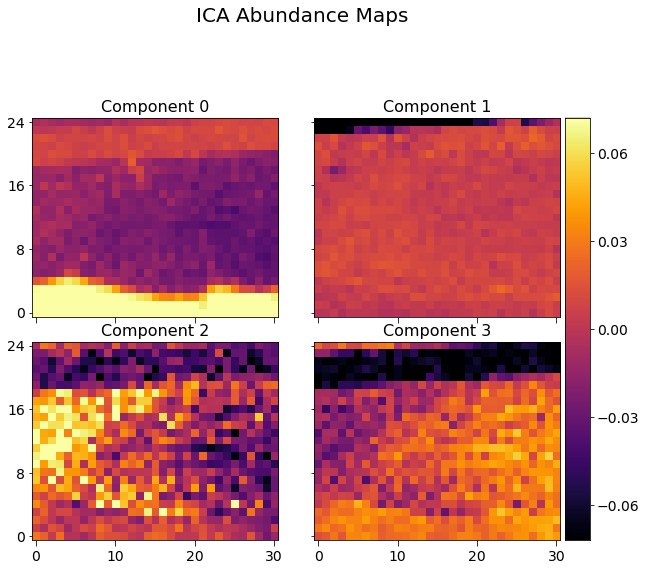

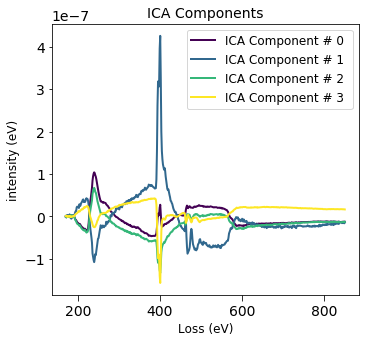

In [20]:
num_comps = 4

#Choose the ICA model from sklearn
ica_model = FastICA(n_components=num_comps, max_iter=200)

# get the data
data_mat = h5_main[:]

decomposer = px.processing.decomposition.Decomposition(h5_main, estimator = ica_model)
h5_ica_group = decomposer.compute()

#pycroscopy can handle this decomposition given an sklearn estimator object
decomposer = px.processing.decomposition.Decomposition(h5_main, estimator =ica_model)
h5_ica_group = decomposer.compute() #compute it. Saves results into the file and returns reference to it.

components = h5_ica_group['Components'] #Components 
projection  = h5_ica_group['Projection'] #Coefficients/scores

ica_coeffs_fig = usid.plot_utils.plot_map_stack(projection[:].reshape(num_rows,num_cols,-1), num_comps=9, title='ICA Abundance Maps', reverse_dims=True,
                             color_bar_mode='single', cmap='inferno', title_yoffset=0.95)

# Visualize the components:
nmf_comp_fig, axis = plt.subplots(figsize=(5.5, 5))
usid.plot_utils.plot_line_family(axis, h5_spec_vals[:].ravel(), components, label_prefix='ICA Component #')
axis.set_xlabel(x_label, fontsize=12)
axis.set_ylabel(y_label, fontsize=12)
axis.set_title('ICA Components', fontsize=14)
axis.legend(bbox_to_anchor=[1.0, 1.0], fontsize=12)


# 4. KMeans Clustering
====================

KMeans clustering is a quick and easy method to determine the types of spectral responses present in the
data. It is not a decomposition method, but a basic clustering method. The user inputs the number of
clusters (sets) to partition the data into. The algorithm proceeds to find the optimal labeling
(ie., assignment of each spectra as belonging to the k<sup>th</sup> set) such that the within-cluster
sum of squares is minimized.

Set the number of clusters below



Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: Cluster has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_001/Raw_Data-Cluster_001" (6 members)>]
Returning previously computed results from: /Measurement_000/Channel_001/Raw_Data-Cluster_001
set the "override" flag to True to recompute results


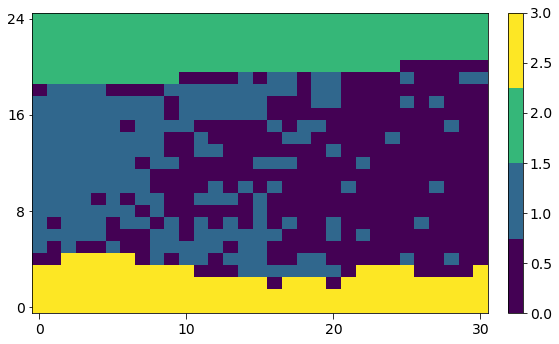

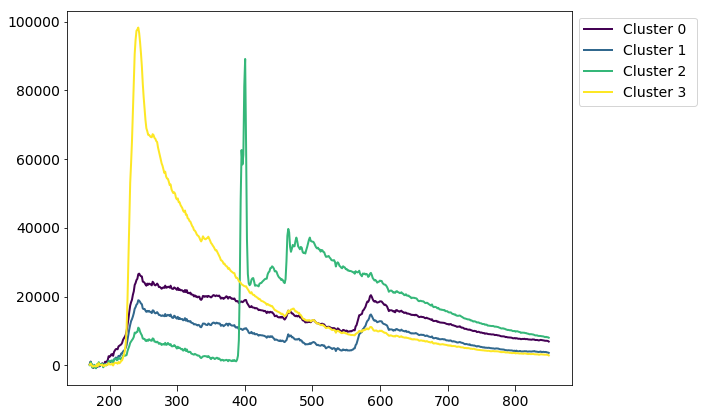

In [10]:
num_clusters = 4

estimator = px.processing.Cluster(h5_main, KMeans(n_clusters=num_clusters))
h5_kmeans_grp = estimator.compute(h5_main)
h5_kmeans_labels = h5_kmeans_grp['Labels']
h5_kmeans_mean_resp = h5_kmeans_grp['Mean_Response']

fig_labels =cluster_utils.plot_cluster_labels(h5_kmeans_labels[:].reshape(num_rows,num_cols),
                                              num_clusters = num_clusters, figsize = (8,5))
fig_centroids =cluster_utils.plot_cluster_centroids(h5_kmeans_mean_resp[:], h5_spec_vals[:].ravel(), figsize = (10,6))


# Close the file

After processing, good practice to close the file. 

In [21]:
h5_file.close()